# Applied Data Science Capstone Project: IL CANE'S CAMION
#### by Jeanna Schoonmaker

### Introduction

#### According to the American Pet Products Association, spending on pet-related expenditures in the United States was predicted to increase to 75 billion dollars in 2019 (American Pet Products). However, pets and pet ownership are not just big business - pets were regarded as members of the family by 95% of pet owners in a 2015 Harris Poll. The same poll showed that 71% of the pet owning respondents owned dogs, and that 68% of pet owners reported their household income as 100k+ (The Harris Poll).

#### Another trend in the past decade: food trucks. The “mobile food” industry was estimated to grow to 900 million in 2019, and nearly 25% of food truck operators cited staying ahead of changing trends as a reason for launching a mobile business (Saxe). 

#### To capitalize on this pet-friendly trend, as well as the popularity of food trucks, world famous restaurateurs Fido and Max have decided to launch a new venture: Il Cane's Camion, which is Italian for "The Dog's Truck". This dog-centric food truck plans to cater to the most discriminating of poochy palates by offering fresh, organic doggie treats, made especially for use by families who want to lavish love and attention on their dogs (with an option for further pet products to be included in the future).

#### In order to consider good business locations for Il Cane’s Camion, Fido and Max are looking for a major US city with a high population of pet owners and many dog-friendly venues that would increase the likelihood of local foot traffic. Research will be done on the 5 largest major metropolitan areas within the United States, by population, as possible business sites. The key indicators to be considered are a) the percentage of the city's population who are pet owners, and b) population density, since high foot traffic is considered one of the most important features of food truck success (Murray). Once a city has been chosen, suggested city locations, identified as those centralized in a cluster of businesses catering to dogs, will be mapped as possible daily or weekly parking spots for Il Cane's Camion.

### The business questions to be considered are:
    
1.	What is the population density of the 5 largest US cities?
2.	What percentage of the population are pet owners in the 5 largest cities (by population) in the United States?

### Once a city has been recommended, research will include:
   
1.	Which areas of the chosen city have veterinarians within close proximity?
2.	Where are the most dog parks located in the chosen city?
3.	Which areas of the chosen city have nearby pet stores and pet services?
4.	Taking all of the above into consideration, use machine learning to find several suggestions for Il Cane's Camion to park and operate.

## ***Please see the full capstone report for all other report sections including data methodology, results, discussion, and works cited. The remainder of this notebook will consist of code and comments only.*** 

### Importing all necessary libraries and modules

In [3]:
import pandas as pd
import requests
import numpy as np
from bs4 import BeautifulSoup
import folium
import os
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import seaborn as sns
from sklearn.cluster import KMeans
import json
from pandas.io.json import json_normalize
from geocodio import GeocodioClient

### Web scraping a table of the largest cities in the United States by population from wikipedia

In [4]:
#Creating BeautifulSoup object, scraping table from wikipedia
req = requests.get("https://en.wikipedia.org/wiki/List_of_United_States_cities_by_population")
soup = BeautifulSoup(req.content,'lxml')
table = soup.find_all('table', class_='wikitable sortable')

#loading into a dataframe
df = pd.read_html(str(table))
city_data = pd.DataFrame(df[0])

#limiting dataframe to data needed for analysis
city_data = city_data.loc[:,['City','2018estimate','2016 population density']]

#setting index for use in merging tables
city_data['Id'] = range(1, len(city_data)+1)
city_data.set_index('Id', inplace=True)

city_data.head(5)

,City,2018estimate,2016 population density
Id,,,
1,New York[d],8398748,"28,317/sq mi"
2,Los Angeles,3990456,"8,484/sq mi"
3,Chicago,2705994,"11,900/sq mi"
4,Houston[3],2325502,"3,613/sq mi"
5,Phoenix,1660272,"3,120/sq mi"


#### Utilized American Housing Survey Table Creator for the 5 biggest US Cities. In the Emergency and Disaster Preparedness results, people were asked about evacuation plans for pets. Each city's "No Pets" answer count will be compared with the estimated total for the city to get the percentage of households who own pets in the 5 biggest US cities.

In [5]:
#loading all csvs as downloaded from the census bureau, then transforming them into dataframes
ny = pd.read_csv(r'C:\Users\J\Downloads\ny.csv', encoding= 'unicode_escape')
la = pd.read_csv(r'C:\Users\J\Downloads\la.csv', encoding= 'unicode_escape')
chi = pd.read_csv(r'C:\Users\J\Downloads\chi.csv', encoding= 'unicode_escape')
hou = pd.read_csv(r'C:\Users\J\Downloads\hou.csv', encoding= 'unicode_escape')
phoenix = pd.read_csv(r'C:\Users\J\Downloads\phoenix.csv', encoding= 'unicode_escape')

# looping through all dataframes, computing number who own pets based on total pop. minus how many reported they had no pets
# then computing percentage of city residents who own pets
df_list = [ny, la, chi, hou, phoenix]
cities = pd.DataFrame()
for x in df_list:
    x = x.loc[:,['Area','Characteristics','Metric: Estimate']]
    x = x.iloc[[0, 51],:]
    x['Owns pets'] = float(x.iloc[0, 2]) - float(x.iloc[1, 2])  
    x['Percent that owns pets'] = x['Owns pets']/float(x.iloc[0,2])
    cities = cities.append(x)

cities = cities.iloc[[0,2,4,6,8],:]
cities = cities.loc[:,['Area', 'Percent that owns pets']]
cities['Id'] = range(1, len(cities)+1)
cities.set_index('Id', inplace=True)
cities

,Area,Percent that owns pets
Id,,
1,New York City,0.330479
2,Los Angeles-Long Beach,0.408922
3,Chicago,0.396257
4,Houston,0.473508
5,Phoenix,0.552741


### Merging dataframes to compare city data

In [6]:
#merging dataframes on Id column
city_choice = pd.merge(cities, city_data, on='Id').drop('City', axis=1)

#modifying population density column to remove string characters and change to numeric values
city_choice['2016 population density'].replace(regex=True,inplace=True,to_replace=r'\D',value=r'')
city_choice['pop density'] = pd.to_numeric(city_choice['2016 population density'])

#modifying Los Angeles city name for ease in data visualization 
city_choice.at[2, 'Area'] = 'Los Angeles'

#normalizing population density
city_choice['pop density'] = ((city_choice["pop density"]-city_choice["pop density"].min())/(city_choice["pop density"].max()-city_choice["pop density"].min()))
city_choice = city_choice.loc[:, ['Area', 'Percent that owns pets', 'pop density']]
city_choice

,Area,Percent that owns pets,pop density
Id,,,
1,New York City,0.330479,1.000000
2,Los Angeles,0.408922,0.212882
3,Chicago,0.396257,0.348454
4,Houston,0.473508,0.019566
5,Phoenix,0.552741,0.000000


### Plotting the percentage of pet owners and population density in 5 largest US cities

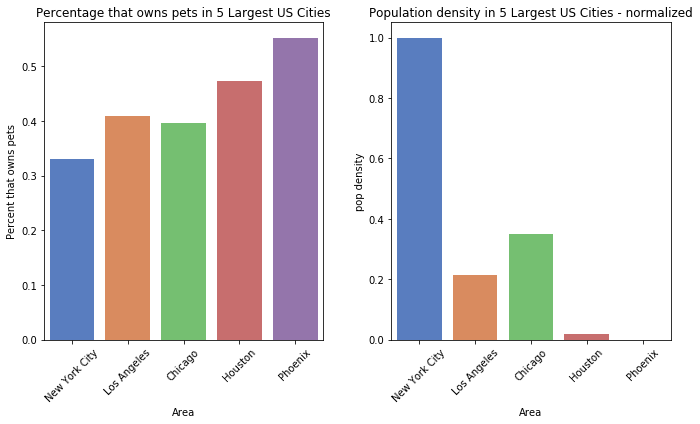

In [7]:
fig, ax =plt.subplots(1,2, figsize=(10, 6))
g = sns.barplot(x="Area", y="Percent that owns pets", data=city_choice, palette="muted", ax=ax[0])
h = sns.barplot(x='Area', y='pop density', data =city_choice, palette='muted', ax=ax[1])
g.set_title('Percentage that owns pets in 5 Largest US Cities')
h.set_title('Population density in 5 Largest US Cities - normalized')
plt.setp(g.get_xticklabels(), rotation=45)
plt.setp(h.get_xticklabels(), rotation=45)
fig.tight_layout()
fig.savefig('demo.png')

## After initial data analysis, the stakeholders have decided the city of Chicago has the preferred combination of percentage of the population that owns pets, as well as population density. Research will now focus on the city of Chicago to determine areas with clusters of dog-friendly businesses.

In [1]:
# The code was removed by Watson Studio for sharing.

In [2]:
# The code was removed by Watson Studio for sharing.

### Using the Geocodio API to get Chicago latitude and longitude data

In [10]:
client = GeocodioClient(geo_id)
location = client.geocode("Chicago, IL")

In [11]:
Chicago_lat = location['results'][60]['location']['lat']
Chicago_long = location['results'][60]['location']['lng']
print(Chicago_lat)
print(Chicago_long)

41.880188
-87.62551


### Using the Foursquare API to get locations of businesses catering to dogs, including the categories of dog runs, veterinarians, pet stores, and pet services

In [12]:
LIMIT = 500
radius = 8000

#Foursquare categoryId for dog runs, per https://developer.foursquare.com/docs/resources/categories
categoryId='4bf58dd8d48988d1e5941735'

dog_run_list = []

url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&categoryId={}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    Chicago_lat,
    Chicago_long,
    categoryId,
    radius,
    LIMIT)

dogrun = requests.get(url).json()

dogruns = dogrun['response']['groups'][0]['items']

dog_run_list.append([(
            v['venue']['name'], 
            v['venue']['categories'][0]['name'],
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],) for v in dogruns])

dogruns_df = pd.DataFrame([item for dog_run_list in dog_run_list for item in dog_run_list])
dogruns_df.columns = ['Name', 
                  'Category', 
                  'Latitude', 
                  'Longitude']
dogruns_df.shape

(60, 4)

In [19]:
#Foursquare categoryId for pet service
categoryId='5032897c91d4c4b30a586d69'

services_list = []

url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&categoryId={}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    Chicago_lat,
    Chicago_long,
    categoryId,
    radius,
    LIMIT)

service = requests.get(url).json()

services = service['response']['groups'][0]['items']

services_list.append([(
            v['venue']['name'], 
            v['venue']['categories'][0]['name'],
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],) for v in services])

services_df = pd.DataFrame([item for services_list in services_list for item in services_list])
services_df.columns = ['Name', 
                  'Category', 
                  'Latitude', 
                  'Longitude']
services_df.shape

(100, 4)

In [20]:
#Foursquare categoryId for pet store
categoryId='4bf58dd8d48988d100951735'

petstore_list = []

url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&categoryId={}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    Chicago_lat,
    Chicago_long,
    categoryId,
    radius,
    LIMIT)

store = requests.get(url).json()

stores = store['response']['groups'][0]['items']

petstore_list.append([(
            v['venue']['name'], 
            v['venue']['categories'][0]['name'],
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],) for v in stores])

petstore_df = pd.DataFrame([item for petstore_list in petstore_list for item in petstore_list])
petstore_df.columns = ['Name', 
                  'Category', 
                  'Latitude', 
                  'Longitude']
petstore_df.shape

(87, 4)

In [21]:
vets_list = []

#Foursquare categoryId for veterinarian
categoryId='4d954af4a243a5684765b473'

url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&categoryId={}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    Chicago_lat,
    Chicago_long,
    categoryId,
    radius,
    LIMIT)

vet = requests.get(url).json()

vets = vet['response']['groups'][0]['items']

vets_list.append([(
            v['venue']['name'], 
            v['venue']['categories'][0]['name'],
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],) for v in vets])

vets_df = pd.DataFrame([item for vets_list in vets_list for item in vets_list])
vets_df.columns = ['Name', 
                  'Category', 
                  'Latitude', 
                  'Longitude']
vets_df.shape

(53, 4)

### Map of Chicago with dog-friendly business locations marked

In [22]:
# create initial map of Chicago using latitude and longitude values
map_chicago = folium.Map(location=[Chicago_lat, Chicago_long], zoom_start=12)

title_html = '''
             <h3 align="center" style="font-size:20px"><b>Chicago's Dog-Centric Locations, including Dog Runs, Pet Stores, Pet Services and Vet Services</b></h3>
             '''
map_chicago.get_root().html.add_child(folium.Element(title_html))

# add vet markers to map
for lat, lng, category, name in zip(vets_df['Latitude'], vets_df['Longitude'], vets_df['Category'], vets_df['Name']):
    label = '{}, {}'.format(category, name)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_chicago)  
    
# add pet store markers to map
for lat, lng, category, name in zip(petstore_df['Latitude'], petstore_df['Longitude'], petstore_df['Category'], petstore_df['Name']):
    label = '{}, {}'.format(category, name)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='#ff0000',
        fill_opacity=0.5,
        parse_html=False).add_to(map_chicago)  
    
# add pet services markers to map
for lat, lng, category, name in zip(services_df['Latitude'], services_df['Longitude'], services_df['Category'], services_df['Name']):
    label = '{}, {}'.format(category, name)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='green',
        fill=True,
        fill_color='#008000',
        fill_opacity=0.5,
        parse_html=False).add_to(map_chicago)  
    
# add dog run markers to map
for lat, lng, category, name in zip(dogruns_df['Latitude'], dogruns_df['Longitude'], dogruns_df['Category'], dogruns_df['Name']):
    label = '{}, {}'.format(category, name)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='purple',
        fill=True,
        fill_color='a64ca6',
        fill_opacity=0.5,
        parse_html=False).add_to(map_chicago)
    
map_chicago.save("test.html")
os.system('test.html')
map_chicago

### Concatenating all dog-related locations into one dataframe listing name, latitude, and longitude for use in KMeans clustering

In [23]:
df = pd.concat([dogruns_df, services_df, petstore_df, vets_df])
X=df.loc[:,['Name','Latitude','Longitude']]
X.head(5)

,Name,Latitude,Longitude
0,Lakeshore East Dog Park,41.885752,-87.618498
1,Heritage Green Park,41.879779,-87.640068
2,Larrabee Dog Park,41.894430,-87.643044
3,Mary Bartelme Dog Park,41.879801,-87.650472
4,Grant Bark Park,41.870443,-87.621696


### Plotting an elbow curve graph to determine optimal number of clusters for KMeans

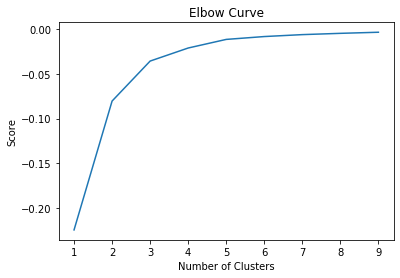

In [24]:
#Iterating through k values to create elbow curve visualization
K_clusters = range(1,10)
kmeans = [KMeans(n_clusters=i) for i in K_clusters]
Y_axis = X[['Latitude']]
X_axis = X[['Longitude']]
score = [kmeans[i].fit(Y_axis).score(Y_axis) for i in range(len(kmeans))]

# Plotting elbow curve
plt.plot(K_clusters, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.savefig('elbow')

### Elbow curve occurs at k = 3, which will be the value used for K Means clustering. Then the cluster centers' latitude and longitude values will be computer and mapped

In [25]:
k = 3
kmeans = KMeans(n_clusters = k, init ='k-means++')

#Compute K Means clustering and fit to lat/long column of dataset
kmeans.fit(X[X.columns[1:3]])
X['cluster_label'] = kmeans.fit_predict(X[X.columns[1:3]])

#Coordinates for cluster centers
centers = kmeans.cluster_centers_

#Labels for each point
labels = kmeans.predict(X[X.columns[1:3]])
print(labels)

#Putting centers' coordinates into dataframe for mapping
centers_df = pd.DataFrame(centers)
centers_df.columns = ['Latitude', 'Longitude']
print(centers_df)
X.tail(5)

[0 0 0 0 0 0 0 2 2 0 1 2 0 0 1 2 0 2 2 1 2 2 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 1 1 0 2 1 2 2 1 2 2 2 1 1 0 1 1 0 0 0 0 0 2 0 0 1 2 2 1 0 2 1
 1 1 0 2 2 0 2 1 1 0 1 2 1 0 2 1 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 2
 1 2 2 1 0 0 0 1 2 1 2 1 2 2 1 2 2 1 2 2 1 0 0 2 1 0 2 2 2 0 1 1 2 2 2 2 2
 1 1 1 1 2 1 2 1 1 1 1 1 0 0 0 0 1 1 2 0 2 0 0 1 2 0 1 1 1 0 1 1 0 2 2 0 2
 1 0 1 0 1 1 1 0 0 0 0 0 0 0 0 0 1 1 0 1 1 0 0 1 0 0 1 2 1 2 2 2 2 1 1 1 2
 2 2 2 1 0 1 1 1 0 2 1 1 1 1 2 2 2 2 1 2 2 1 1 1 1 0 0 0 1 0 1 2 2 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 2 2 0 2 2 2 2 1 1 0 2 2 2 2 1 1 2 1 1 2 1
 1 1 1 0]
    Latitude  Longitude
0  41.874899 -87.638419
1  41.924711 -87.651300
2  41.906072 -87.680651


,Name,Latitude,Longitude,cluster_label
48,Pets First Veterinary Clinic,41.943755,-87.644989,1
49,Roscoe View Animal Clinic,41.939317,-87.671517,1
50,Higgins Animal Clinic,41.939650,-87.671462,1
51,Wrigleyville Veterinary Center,41.948889,-87.649093,1
52,Brighton Park Animal Hospital,41.824741,-87.686716,0


### Map of 3 clusters identified through K Means, showing dog-friendly 'hot spots' in Chicago, with the centers identified in black and representing optimal parking areas for Il Cane's Camion

In [26]:
cluster_map = folium.Map(location=[Chicago_lat, Chicago_long], zoom_start=12)

title_html = '''
             <h3 align="center" style="font-size:20px"><b>Possible Il Cane's Camion Locations - 3 Main Clusters of Dog-Centric Locations in Chicago, IL</b></h3>
             '''
cluster_map.get_root().html.add_child(folium.Element(title_html))

# colors for map
x = np.arange(k)
ys = [i + x + (i*x)**2 for i in range(k)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# dog-friendly location markers
markers_colors = []
for lat, lon, cluster in zip(X['Latitude'], X['Longitude'], X['cluster_label']):
    label = folium.Popup(' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster],
        opacity=0.4,
        fill=True,
        fill_color=rainbow[cluster],
        fill_opacity=0.4).add_to(cluster_map)

# cluster markers
for lat, lon, cluster in zip(centers_df['Latitude'], centers_df['Longitude'], centers_df.index):
    label = folium.Popup(' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=30,
        popup=label,
        color=rainbow[cluster],
        fill=True,
        fill_color=rainbow[cluster],
        fill_opacity=0.5).add_to(cluster_map)
    
# cluster markers to highlight centers of clusters
for lat, lon, cluster in zip(centers_df['Latitude'], centers_df['Longitude'], centers_df.index):
    label = folium.Popup(' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=2,
        popup=label,
        color='black',
        fill=True,
        fill_color='dark gray',
        fill_opacity=0.5).add_to(cluster_map)

cluster_map.save("cluster.html")
os.system('cluster.html')    
cluster_map